In [1]:
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import numpy as np
import itertools
import random

from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import BertModel, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import DistilBertModel, AdamW
from transformers import BertForSequenceClassification

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from pandarallel import pandarallel
pandarallel.initialize()

import os
os.chdir('..')

from src.data_lexical import LexDataset, read_lexical_corpus
from src.data_disambiguation import DisDataset, read_disambiguation_corpus
from src.model import BertForSharedTaskBaseline
from src.training import train, evaluate, forward_func_custom_bert

Using TensorFlow backend.


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
import math
import os
import warnings
from dataclasses import dataclass
from typing import Optional, Tuple

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import BertPreTrainedModel, BertModel
from transformers.modeling_outputs import SequenceClassifierOutput


class BertForSharedTaskMultitask(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels_first_task = 1 # Regression
        self.num_labels_second_task = config.num_labels # Word sense disambiguation

        self.bert = BertModel(config)
        self.dropout_first = nn.Dropout(config.hidden_dropout_prob)
        self.dropout_second = nn.Dropout(config.hidden_dropout_prob)
        
        self.classifier_first = nn.Linear(config.hidden_size, self.num_labels_first_task)
        self.classifier_second = nn.Linear(config.hidden_size, self.num_labels_second_task)

        self.init_weights()
        

    def forward(
        self,
        input_ids=None,
        target_positions=None,
        task_id=1,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        if task_id == 1:
            pooled_output = outputs[0][torch.arange(outputs[0].size(0)), target_positions]
            pooled_output = self.dropout_first(pooled_output)
            logits = self.classifier_first(pooled_output)

            loss = None
            if labels is not None:
                if self.num_labels_first_task == 1:
                    #  We are doing regression
                    loss_fct = MSELoss()
                    loss = loss_fct(logits.view(-1), labels.view(-1))
                else:
                    loss_fct = CrossEntropyLoss()
                    loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output

            return SequenceClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )
        elif task_id == 2:
            sequence_output = outputs[0]

            sequence_output = self.dropout_second(sequence_output)
            logits = self.classifier_second(sequence_output)

            loss = None
            if labels is not None:
                loss_fct = CrossEntropyLoss()
                # Only keep active parts of the loss
                if attention_mask is not None:
                    active_loss = attention_mask.view(-1) == 1
                    active_logits = logits.view(-1, self.num_labels_second_task)
                    active_labels = torch.where(
                        active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                    )
                    loss = loss_fct(active_logits, active_labels)
                else:
                    loss = loss_fct(logits.view(-1, self.num_labels_second_task), labels.view(-1))

            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output

            return TokenClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )


In [3]:
def forward_func_multitask_bert(batch, device, model, additional_params):

    # Clear gradients
    model.zero_grad()      
    b_input_ids = batch['input_ids'].to(device)
    b_input_mask = batch['attention_mask'].to(device)
        
    if additional_params['task_id'] == 1:
        b_labels = batch['labels'].to(device)
        b_positions =  batch['target_positions'].to(device)
      
        loss, logits = model(b_input_ids, 
                             b_positions,
                             task_id=1,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
    elif additional_params['task_id'] == 2:
        b_labels = batch['labels'].to(device)

        loss, logits = model(b_input_ids, 
                             task_id=2,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
    return loss, logits

In [4]:
epochs = 40
seed_val = 42
results_window = {}
max_len = 22
stop_at = 5

In [5]:
data_sent_dis, data_senses_dis = read_disambiguation_corpus(max_len=max_len)

In [6]:
len(data_sent_dis)

7932

In [7]:
tag_values = list(set(list(itertools.chain(*data_senses_dis))))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [8]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [9]:
train_encodings_dis = tokenizer(list(data_sent_dis), truncation=True, padding=True, max_length=max_len)

data_tags_dis = pad_sequences([[tag2idx.get(l) for l in lab] for lab in data_senses_dis],
                     maxlen=max_len, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
train_dataset_dis = DisDataset(train_encodings_dis, data_tags_dis)

train_loader_dis = DataLoader(train_dataset_dis, batch_size=32)

In [ ]:
import random
import numpy as np
from transformers import get_linear_schedule_with_warmup

for window_x in [0, 1, 2]:
    print('Window size of ', window_x)
    data_texts, data_corpus, data_labels, sentence_raw, target_words, positions = read_lexical_corpus('data/raw/lcp_single_train.tsv',
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    torch.cuda.manual_seed_all(seed_val)

    kf = StratifiedKFold(8, shuffle=True, random_state=0)

    history_preds = []
    history_samples = []
    history_input = []
    history_target = []
    history_index = []
    history_labels = []
    history_occur_text = []
    history_occur_target = []
    ix_fold = 0

    for train_index, val_index in kf.split(data_texts, data_corpus):
        print('Starting a new fold ...')

        train_texts_lex, train_labels_lex, train_positions_lex, train_target_words_lex = data_texts[train_index], data_labels[train_index], positions[train_index], target_words[train_index]
        val_texts_lex, val_labels_lex, val_positions_lex, val_target_words_lex = data_texts[val_index], data_labels[val_index], positions[val_index], target_words[val_index]

        train_encodings_lex = tokenizer(list(train_texts_lex), truncation=True, padding=True)
        train_dataset_lex = LexDataset(train_encodings_lex, train_labels_lex, train_positions_lex)

        val_encodings_lex = tokenizer(list(val_texts_lex), truncation=True, padding=True)
        val_dataset_lex = LexDataset(val_encodings_lex, val_labels_lex, val_positions_lex)

        train_loader_lex = DataLoader(train_dataset_lex, batch_size=16)
        val_loader_lex = DataLoader(val_dataset_lex, batch_size=1)
        
        all_text = ' '.join(train_texts_lex)
        occurence_text = [all_text.count(w) for w in val_target_words_lex]
        
        occurence_target = [train_target_words_lex.tolist().count(w) for w in val_target_words_lex]
        
        device = torch.device("cuda:1")
        
        model = BertForSharedTaskMultitask.from_pretrained(
            "bert-base-uncased", 
            num_labels = len(tag2idx), 
            output_attentions = False, 
            output_hidden_states = False, 
        )
        model.cuda(1)
        device = torch.device("cuda:1")

        optimizer_lex = AdamW(model.parameters(),
                          lr = 2e-5, 
                          eps = 1e-8
                        )

        total_steps = len(train_loader_lex) * epochs
        scheduler_lex = get_linear_schedule_with_warmup(optimizer_lex, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
        
        optimizer_dis = AdamW(model.parameters(),
                          lr = 2e-5, 
                          eps = 1e-8
                        )

        total_steps = len(train_loader_dis) * epochs
        scheduler_dis = get_linear_schedule_with_warmup(optimizer_dis, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        
        tracking_metrics = []
        tracking_logits = []
        early_stopping = 0
        best_metric = 1000000
        
        for epoch_i in range(0, epochs):
            print()
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            train(device, model, train_loader_dis, forward_func_multitask_bert, optimizer_dis, scheduler_dis, {'task_id': 2})
            train(device, model, train_loader_lex, forward_func_multitask_bert, optimizer_lex, scheduler_lex, {'task_id': 1})
            
            training_stats, all_logits, val_metric = evaluate(device, model, val_loader_lex, forward_func_multitask_bert, {'task_id': 1})
            
            tracking_metrics.append(val_metric)
            tracking_logits.append(all_logits)
            
            if val_metric > best_metric:
                early_stopping += 1
            else:
                best_metric = val_metric
                early_stopping = 0
                
            if early_stopping == stop_at:
                break
            
        index_min = np.argmin(tracking_metrics)
        
        history_labels.extend(val_labels_lex)
        history_preds.extend(tracking_logits[index_min])
        history_samples.extend(val_texts_lex)
        history_input.extend(sentence_raw[val_index])
        history_target.extend(target_words[val_index])
        history_index.extend(([ix_fold] * len(val_index)))
        history_occur_text.extend(occurence_text)
        history_occur_target.extend(occurence_target)
        ix_fold += 1

        print("")
        print("Training complete!")
        
        del model
        torch.cuda.empty_cache()
        
    results = pd.DataFrame()
    results['samples'] = history_samples
    results['preds'] = history_preds
    results['true_val'] = history_labels
    results['raw'] = history_input
    results['raw'] = results['raw'].astype(str)
    results['target'] = history_target
    results['index'] = history_index
    results['occur_text'] = history_occur_text
    results['occur_target'] = history_occur_target
    
    results_window[window_x] = results

Window size of  0
Starting a new fold ...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 40 ========
Training...

  Average training loss: 1.670760
Training...

  Average training loss: 0.015420

Running Validation...
  Metric: 0.288065
  Validation Loss: 0.096478

======== Epoch 2 / 40 ========
Training...

  Average training loss: 1.226047
Training...

  Average training loss: 0.016062

Running Validation...
  Metric: 0.269072
  Validation Loss: 0.084310

======== Epoch 3 / 40 ========
Training...

  Average training loss: 1.077137
Training...

  Average training loss: 0.012564

Running Validation...
  Metric: 0.251847
  Validation Loss: 0.073901

======== Epoch 4 / 40 ========
Training...

  Average training loss: 0.924354
Training...

  Average training loss: 0.011904

Running Validation...
  Metric: 0.247354
  Validation Loss: 0.071575

======== Epoch 5 / 40 ========
Training...

  Average training loss: 0.870564
Training...

  Average training loss: 0.013349

Running Validation...
  Metric: 0.242340
  Validation Loss: 0.068811

======== Epoch 6 / 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 40 ========
Training...

  Average training loss: 1.708006
Training...

  Average training loss: 0.022112

Running Validation...
  Metric: 0.274802
  Validation Loss: 0.088449

======== Epoch 2 / 40 ========
Training...

  Average training loss: 1.208319
Training...

  Average training loss: 0.019754

Running Validation...
  Metric: 0.292905
  Validation Loss: 0.098773

======== Epoch 3 / 40 ========
Training...

  Average training loss: 1.041377
Training...

  Average training loss: 0.016821

Running Validation...
  Metric: 0.242039
  Validation Loss: 0.069047

======== Epoch 4 / 40 ========
Training...

  Average training loss: 0.957277
Training...

  Average training loss: 0.016101

Running Validation...
  Metric: 0.255499
  Validation Loss: 0.076708

======== Epoch 5 / 40 ========
Training...

  Average training loss: 0.867564
Training...

  Average training loss: 0.014824

Running Validation...
  Metric: 0.259420
  Validation Loss: 0.077568

======== Epoch 6 / 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 40 ========
Training...

  Average training loss: 1.698877
Training...

  Average training loss: 0.020109

Running Validation...
  Metric: 0.273036
  Validation Loss: 0.088038

======== Epoch 2 / 40 ========
Training...

  Average training loss: 1.183216
Training...

  Average training loss: 0.014485

Running Validation...
  Metric: 0.280963
  Validation Loss: 0.091937

======== Epoch 3 / 40 ========
Training...

  Average training loss: 1.139629
Training...

  Average training loss: 0.013685

Running Validation...
  Metric: 0.267186
  Validation Loss: 0.082882

======== Epoch 4 / 40 ========
Training...

  Average training loss: 0.993843
Training...

  Average training loss: 0.013967

Running Validation...
  Metric: 0.242968
  Validation Loss: 0.070050

======== Epoch 5 / 40 ========
Training...

  Average training loss: 0.881235
Training...

  Average training loss: 0.013292

Running Validation...
  Metric: 0.234643
  Validation Loss: 0.065603

======== Epoch 6 / 

In [11]:
print(8)

8


In [12]:
for window_ix in results_window:
    results_window[window_ix]['mae'] = results_window[window_ix].apply(lambda x: mean_absolute_error([x.preds],[x.true_val]), axis=1)
    results_window[window_ix]['mse'] = results_window[window_ix].apply(lambda x: mean_squared_error([x.preds],[x.true_val]), axis=1)
    results_window[window_ix]['discrete_occur'] = results_window[window_ix].apply(lambda x: x.occur_target if (x.occur_target == 0 or x.occur_target == 1) else 2, axis=1)
    

In [21]:
for window_ix in results_window:
    print('Window of', window_ix)

    mae = results_window[window_ix].groupby(['index']).mae.mean()
    mse = results_window[window_ix].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    #print('R2  --- Mean:', round(np.mean(r_2), 4), ' Std:', round(np.std(r_2), 4))
    print()


Window of 0
MAE --- Mean: 0.136  Std: 0.0839
MSE --- Mean: 0.0315  Std: 0.0301

Window of 1
MAE --- Mean: 0.151  Std: 0.0774
MSE --- Mean: 0.0359  Std: 0.027

Window of 2
MAE --- Mean: 0.1691  Std: 0.077
MSE --- Mean: 0.0424  Std: 0.0282



In [14]:
results_window[0].groupby(['index']).mae.mean()

index
0    0.068610
1    0.242039
2    0.074272
3    0.242737
4    0.068157
5    0.072337
6    0.247907
7    0.071564
Name: mae, dtype: float64

In [15]:
for window_ix in results_window:
    df_temp = results_window[window_ix].groupby(['index', 'discrete_occur']).agg({'mse': 'mean',
                                                                         'mae': 'mean'}).reset_index()
    df_temp = df_temp.groupby('discrete_occur').agg({'mse': ['mean', 'std'],
                                          'mae': ['mean', 'std']}).reset_index()
    df_temp.columns = ['_'.join(col).strip('_') for col in df_temp.columns]
    print('Window of', window_ix)
    print(df_temp)
    print()

Window of 0
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.028456  0.026467  0.130408  0.076747
1               1  0.031792  0.030209  0.139498  0.084515
2               2  0.032659  0.035345  0.137200  0.097068

Window of 1
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.032033  0.023874  0.142877  0.070688
1               1  0.035121  0.027347  0.150642  0.080588
2               2  0.037911  0.031631  0.154789  0.088973

Window of 2
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.037772  0.026019  0.158651  0.071722
1               1  0.040963  0.028532  0.167458  0.078229
2               2  0.045039  0.032671  0.174302  0.088669



In [17]:
import spacy

nlp = spacy.load("en_core_web_sm")
def find_pos(sentence, ref):
    try:
        doc = nlp(sentence)
        for token in doc:
            if token.text == ref:
                return token.pos_
        return np.nan            
    except:
        return np.nan

In [18]:
for window_ix in results_window:
    print(window_ix)
    results_window[window_ix]['pos_label'] =  results_window[window_ix].apply(lambda x: find_pos(x.raw, x.target), axis=1)
    

0
1
2


Window size of: 0


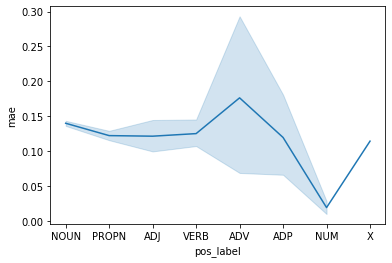

Window size of: 1


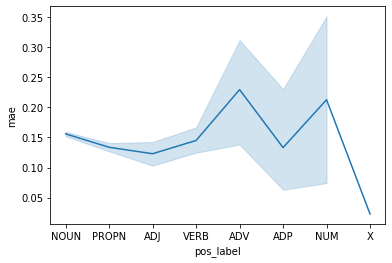

Window size of: 2


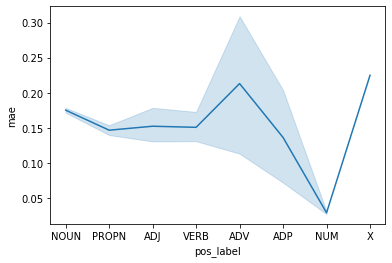

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

for window_ix in results_window:
    print('Window size of:', window_ix)
    sns.lineplot(x='pos_label', y='mae', data=results_window[window_ix].loc[results_window[window_ix].pos_label.notnull()], ci=98, markers='o')
    plt.show()

Window size of: 0


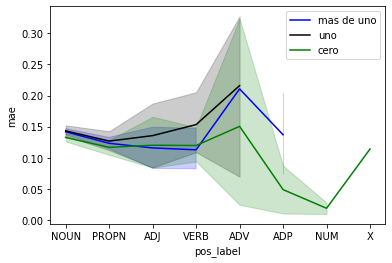

Window size of: 1


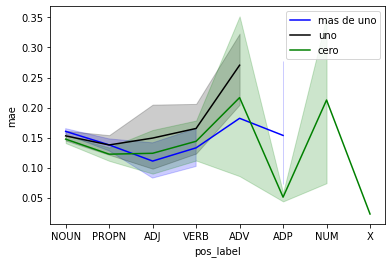

Window size of: 2


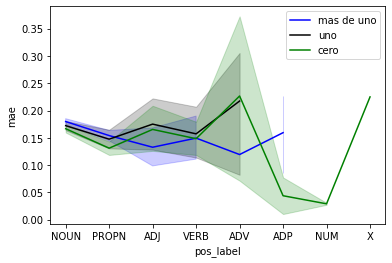

In [20]:
for window_ix in results_window:
    print('Window size of:', window_ix)
    results_many = results_window[window_ix].loc[results_window[window_ix].discrete_occur > 1].reset_index(drop=True)
    results_one = results_window[window_ix].loc[results_window[window_ix].discrete_occur == 1].reset_index(drop=True)
    results_zero = results_window[window_ix].loc[results_window[window_ix].discrete_occur == 0].reset_index(drop=True)
    
    p1 = sns.lineplot(x='pos_label', y='mae', data=results_many.loc[results_many.pos_label.notnull()], ci=98, markers='o', color='blue')
    p2 = sns.lineplot(x='pos_label', y='mae', data=results_one.loc[results_one.pos_label.notnull()], ci=98, markers='o', color='black')
    p3 = sns.lineplot(x='pos_label', y='mae', data=results_zero.loc[results_zero.pos_label.notnull()], ci=98, markers='o', color='green')
    plt.legend(['mas de uno', 'uno', 'cero'])
    plt.show()